# Heat equation - Retrieving operator through ODE solving

In [3]:
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DifferentialEquations
using Plots
using GalacticOptim
using MLUtils
using IterTools: ncycle
using LinearAlgebra
using DiffEqSensitivity
using Zygote
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/examples/heat/heat_training.jl")

Main.HeatTraining

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [4]:
t_max = 1.;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

typ = 3;
d = 1.;
k = 1.;
kappa = 0.005;
L = x_max - x_min
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

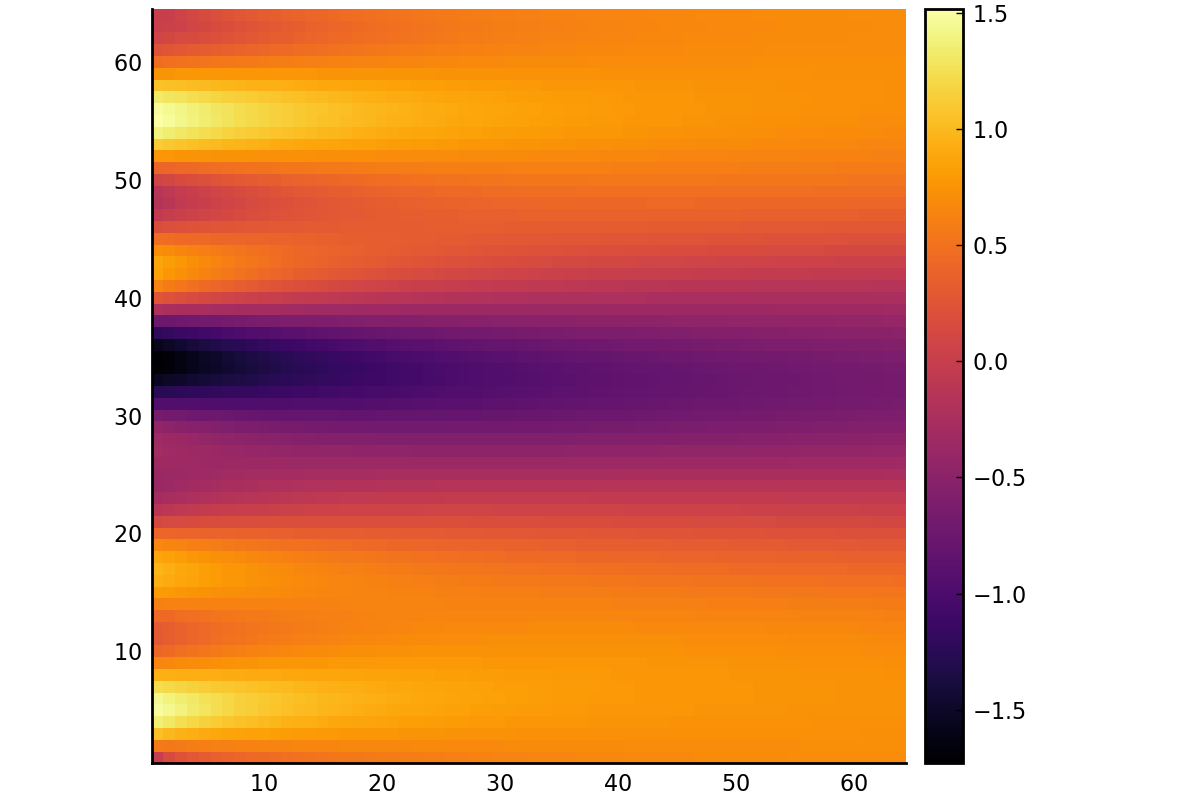

In [4]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.heat_analytical_init(t, x, n, c, kappa);
# u0 = InitialFunctions.high_dim_random_init(t, x);
t, u = Equations.get_heat_fft(t, dx, x_n, kappa, u0[1, :]);
GraphicTools.show_state(u, "") # need to reverse u, odesolver switch dimensions

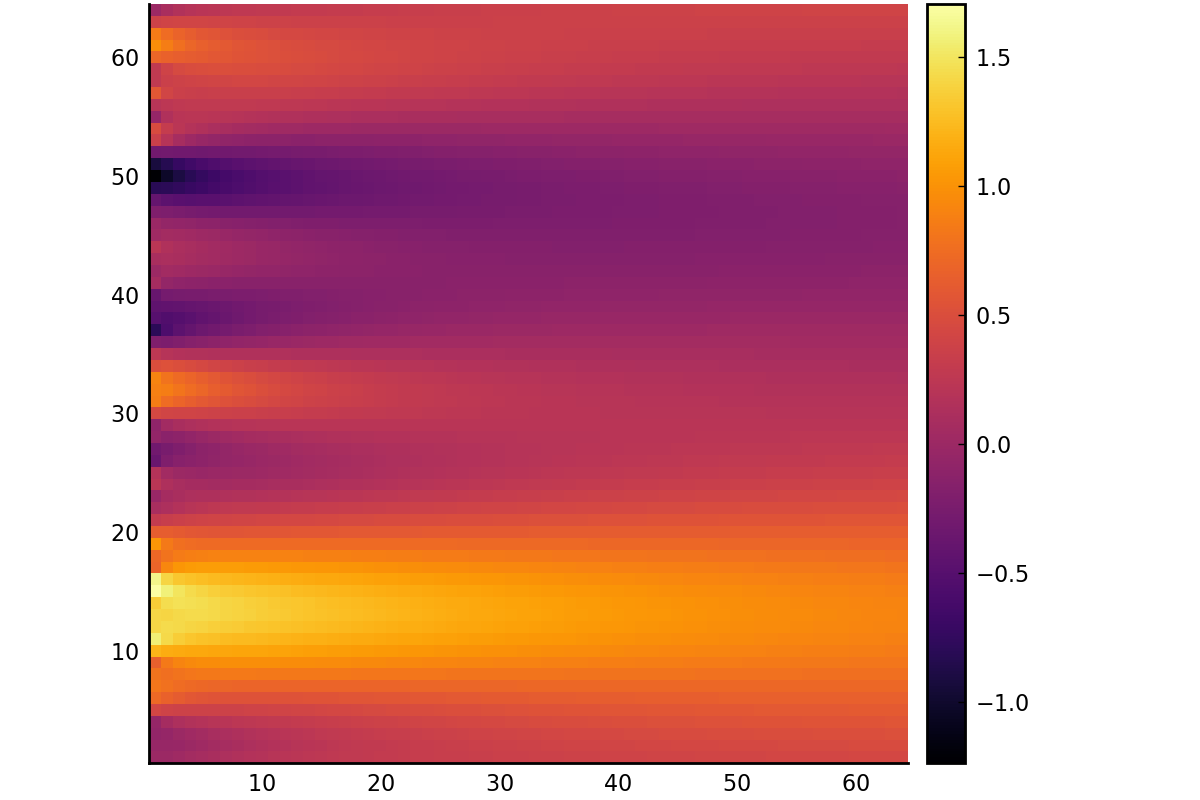

In [5]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 3, kappa, k)
GraphicTools.show_state(u_a, "")

## Generate dataset

In [5]:
# dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 256, 3, kappa, k, "./src/dataset/odesolver_analytical_heat_training_set.jld2", "training_set");
# hand_dataset = Generator.read_dataset("./src/dataset/hand_analytical_heat_training_set.jld2")["training_set"];
analytic_dataset = Generator.read_dataset("./src/dataset/odesolver_analytical_heat_training_set.jld2")["training_set"];
# high_dataset = Generator.read_dataset("./src/examples/heat/heat_high_dim_training_set.jld2")["training_set"];

In [6]:
function check_training_dataset(dataset)
    for i in range(1, 5, step=1)
        a, b, _, d = dataset[i];
        _, c = Equations.get_heat_fft(a, dx, x_n, kappa, b[:, 1]);
        
        display(
            plot(
            GraphicTools.show_state(d, ""),
            GraphicTools.show_state(b, ""),
            GraphicTools.show_state(c, ""),
            GraphicTools.show_err(c, b, "", "t", "x");
            layout = (2, 2),
            );
        );
    end
end

check_training_dataset(analytic_dataset)

LoadError: UndefVarError: dx not defined

---
# Operator reconstruction 

In [14]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, x_n, t_n, typ, kappa, k);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t);
    u_pred = prob_neuralode(u0, res);

    display(
        plot(
            GraphicTools.show_state(u, ""),
            GraphicTools.show_state(hcat(u_pred.u...), ""),
            GraphicTools.show_err(hcat(u_pred.u...), u, "");
            layout = (1, 3),
        )
    )
end

check_result (generic function with 1 method)

In [13]:
function get_data_loader(dataset, batch_size, ratio)
  t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);

  t_train, t_val = splitobs(t, at = ratio);
  train_set, val_set = splitobs(true_set, at = ratio);
  init_train = copy(init_set);
  init_val = copy(val_set[:, :, 1]);

  switch_train_set = permutedims(train_set, (1, 3, 2));
  switch_val_set = permutedims(val_set, (1, 3, 2));

  train_loader = DataLoader((init_train, switch_train_set, collect(ncycle([collect(t_train)], batch_size))), batchsize=batch_size, shuffle=true);
  val_loader = DataLoader((init_val, switch_val_set, collect(ncycle([collect(t_val)], batch_size))), batchsize=batch_size, shuffle=false);

  return (train_loader, val_loader)
end

get_data_loader (generic function with 1 method)

In [15]:
function training(model, epochs, dataset, batch_size, ratio, noise=0., reg=0.)
  opt = Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8);
  ltrain = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = get_data_loader(dataset, batch_size, ratio);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
      tspan = (t[1], t[end]);
      _prob = remake(prob; u0=x, p=p, tspan=tspan);
      Array(solve(_prob, Tsit5(), u0=x, p=p, saveat=t));
  end

  function loss(x, y, t)
      u_pred = predict_neural_ode(x, t[1]);
      ŷ = Reg.gaussian_augment(u_pred, noise);
      l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) + Reg.l2(p, reg); # 1e-5
      return l;
  end

  function traincb()
      ltrain = 0;
      for (x, y, t) in train_loader
           ltrain += loss(x, y, t);
      end
      ltrain /= (train_loader.nobs / train_loader.batchsize);
      @show(ltrain);
  end

    
  function val_loss(x, y, t)
      u_pred = predict_neural_ode(x, t[1]);
      ŷ = u_pred
      l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
      return l;
  end
    
  function evalcb()
      lval = 0;
      for (x, y, t) in val_loader
           lval += val_loss(x, y, t);
      end
      lval /= (val_loader.nobs / val_loader.batchsize);
      @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
        Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
        trigger() && break;
  end

  return re(p), p
end

training (generic function with 3 methods)

In [ ]:
function main()
  batch_size = 128;
  epochs = 1000;

  data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
  model = Models.LinearModel(x_n);
  K, p = training(model, epochs, data, batch_size, 0.7);
  # @save "HeatLinearModel.bson" K
  return K, p
end

K, p = main()

In [ ]:
@save "HeatLinearModelExperiment3.bson" K
# @load "./src/examples/heat/HeatLinearModelExperiment3.bson" K

In [ ]:
data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, true);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
i = 9
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)

In [ ]:
check_result(K, p, 2)

---
## Analysis

### MSE approximated operator

In [8]:
function test_simulation(K, p,  n, typ)
    mse_tot = 0
    l1_tot = 0
    
    for i in 1:n
        t, u0, u_true = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, typ, kappa, k);
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
        u_pred = prob_neuralode(u0, p);
        mse_tot += Flux.mse(u_pred, u_true)
        l1_tot += Flux.mae(u_pred, u_true)
    end
    
    return mse_tot / n, l1_tot / n
end

# test_simulation(K, 100, 3)

test_simulation (generic function with 1 method)

In [18]:
function test_simulation_2(K, p, data, ratio)
    t, init, u = ProcessingTools.process_dataset(data, true);
    t_train, t_val = splitobs(t, at = ratio);
    train_set, val_set = splitobs(u, at = ratio);
    
    n = size(init, 2)
    mse_tot = 0
    l1_tot = 0
    mse_train = 0
    l1_train = 0
    mse_val = 0
    l1_val = 0
    
    for i in 1:n
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
        u0 = init[:, i]
        u_pred = prob_neuralode(u0, p);
        mse_tot += Flux.mse(u_pred, u[:, i, :])
        l1_tot += Flux.mae(u_pred, u[:, i, :])
        
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t_train[1], t_train[end]), Tsit5(), saveat=t_train);
        u0 = init[:, i]
        u_pred = prob_neuralode(u0, p);
        mse_train += Flux.mse(u_pred, train_set[:, i, :])
        l1_train += Flux.mae(u_pred, train_set[:, i, :])
        
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t_val[1], t_val[end]), Tsit5(), saveat=t_val);
        u0 = copy(val_set[:, i, 1]);
        u_pred = prob_neuralode(u0, p);
        mse_val += Flux.mse(u_pred, val_set[:, i, :])
        l1_val += Flux.mae(u_pred, val_set[:, i, :])
    end
    
    return mse_tot / n, l1_tot / n, mse_train / n, l1_train / n, mse_val / n, l1_val / n
end


test_simulation_2 (generic function with 1 method)

In [ ]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, x_n, t_n, 2, kappa, k);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
u_pred = prob_neuralode(u0, p);

GraphicTools.show_state(hcat(u_pred.u...), "")

In [ ]:
GraphicTools.show_state(u, "")

In [ ]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

In [ ]:
GraphicTools.show_state(reverse(Flux.params(K)[1]; dims = 1), "Operator F")

### Regularization

In [10]:
function analyse_model(files, data, ratio)
    sim = 100
    typ = 2
    mse_inters = []
    mse_sets = []
    mse_trains = []
    mse_vals = []
    
    for filename in files
        @load filename K p
        mse_inter, _ = test_simulation(K, p, sim, typ)
        mse_set, _, mse_train_set, _, mse_val_set, _ = test_simulation_2(K, p, data, ratio)
            
        push!(mse_inters, copy(mse_inter))
        push!(mse_sets, copy(mse_set))
        push!(mse_trains, copy(mse_train_set))
        push!(mse_vals, copy(mse_val_set))
    end

    return mse_inters, mse_sets, mse_trains, mse_vals
end

analyse_model (generic function with 1 method)

In [11]:
function analyse_L2_regularization(noise, reg, batch_size, ratio)
    sim = 100
    typ = 2
    epochs = 1000;
    files = []
    
    data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
    
    for e in noise
        for (i, r) in enumerate(reg)
            model = Models.LinearModel(x_n);
            K, p = training(model, epochs, data, batch_size, 0.7, e, r);
            filename = "HeatLinearModelExperiment_noise_gauss_10p_" * string(i) * ".bson"
            @save filename K p
            push!(files, filename)
        end
    end
    
    mse_inters, mse_sets, mse_trains, mse_vals = analyse_model(files, data, ratio)

    return files, mse_inters, mse_sets, mse_trains, mse_vals
end

analyse_L2_regularization (generic function with 1 method)

In [ ]:
a b c d = analyse_L2_regularization(0.1, [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 128, 0.7)

In [20]:
data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
files = []
for (i, r) in enumerate([1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    filename = "./src/examples/heat/reg/HeatLinearModelExperiment_noise_gauss_10p_" * string(i) * ".bson"
    push!(files, filename)
end
a, b, c, d = analyse_model(files, data, 0.7)
@save "./src/examples/heat/reg/heat_cost_regularization_noise_gauss_10p.bson" a b c d

In [17]:
function plot_regularization(noise, reg, a, b, c, d)
    plot(dpi=200)
    plot!(reg, a, markershape=:x, label="Interpolation")
    plot!(reg, b, markershape=:x, label="Full")
    plot!(reg, c, markershape=:x, label="Training")
    plot!(reg, d, markershape=:x, label="Validation")
    plot!(xlabel="Regularization", ylabel="Cost", xaxis=:log)
    plot!(xticks=(reg,["1e-12", "1e-10", "1e-8", "1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1"]))
end

plot_regularization (generic function with 1 method)

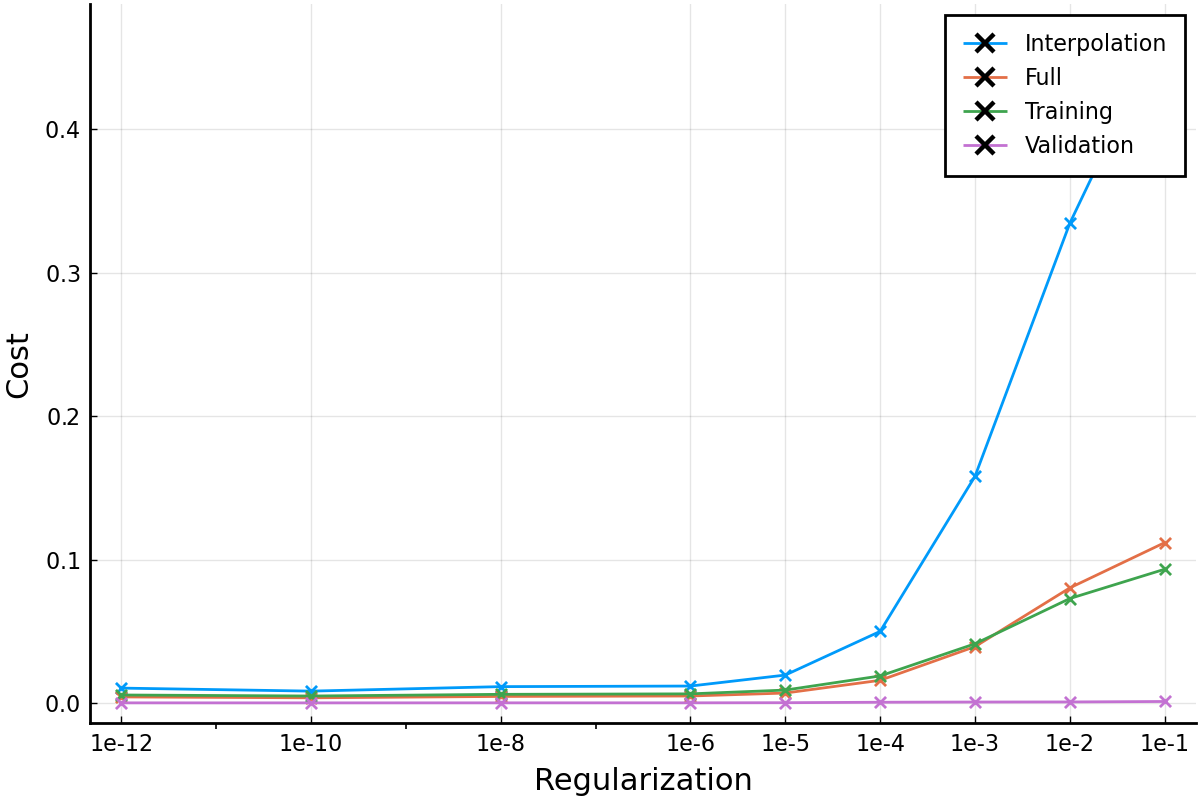

In [153]:
@load "src/examples/heat/reg/heat_cost_regularization_no_noise.bson" a b c d
plot_regularization([0.05], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], a, b, c, d)

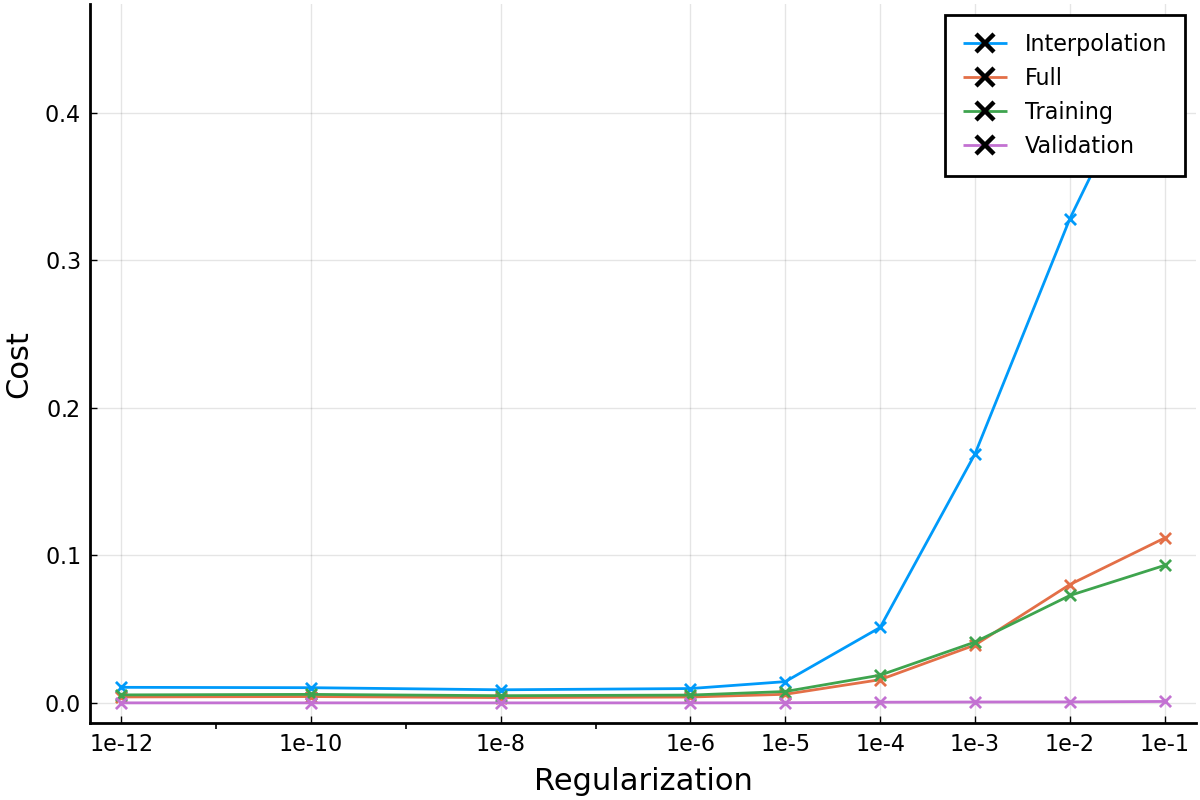

In [134]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_1em5_2.bson" mse_inters mse_sets mse_trains mse_vals
a = mse_inters
b = mse_sets
c = mse_trains
d = mse_vals
plot_regularization([1e-5], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], a, b, c, d)

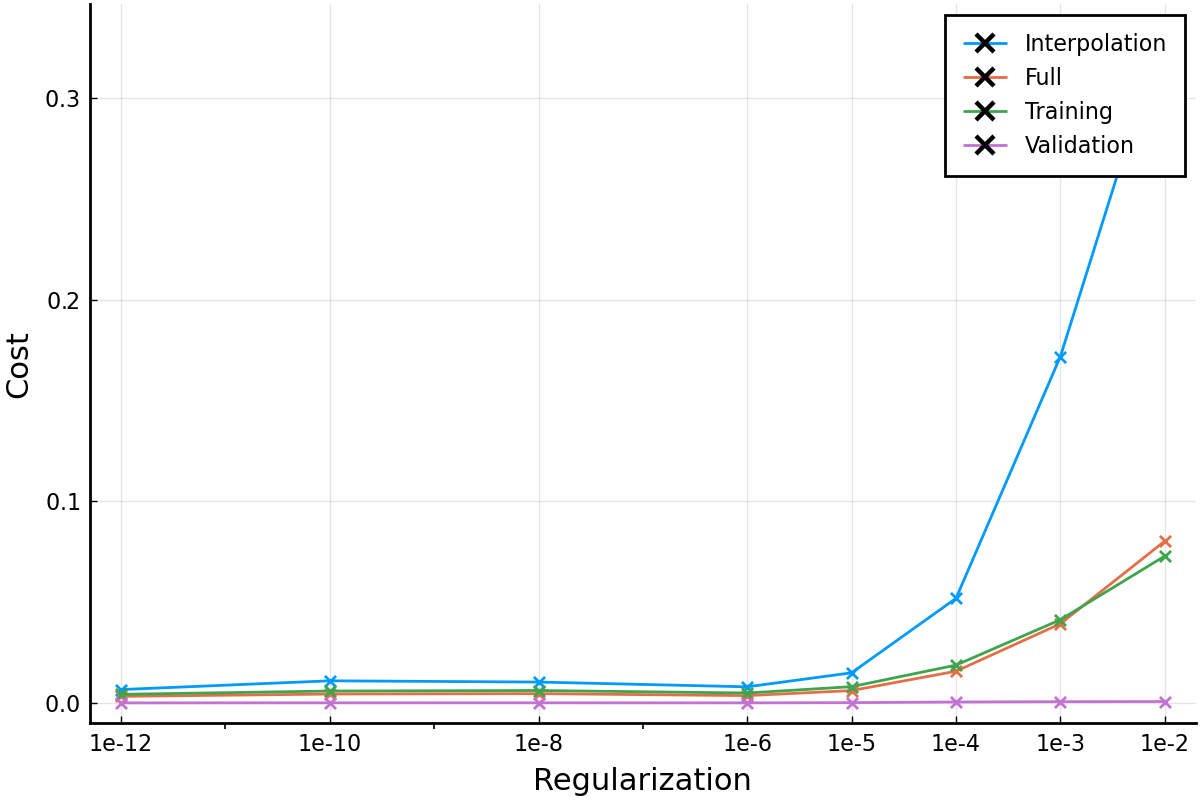

In [130]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_1em3.bson" a b c d
plot_regularization([1e-3], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], a, b, c, d)

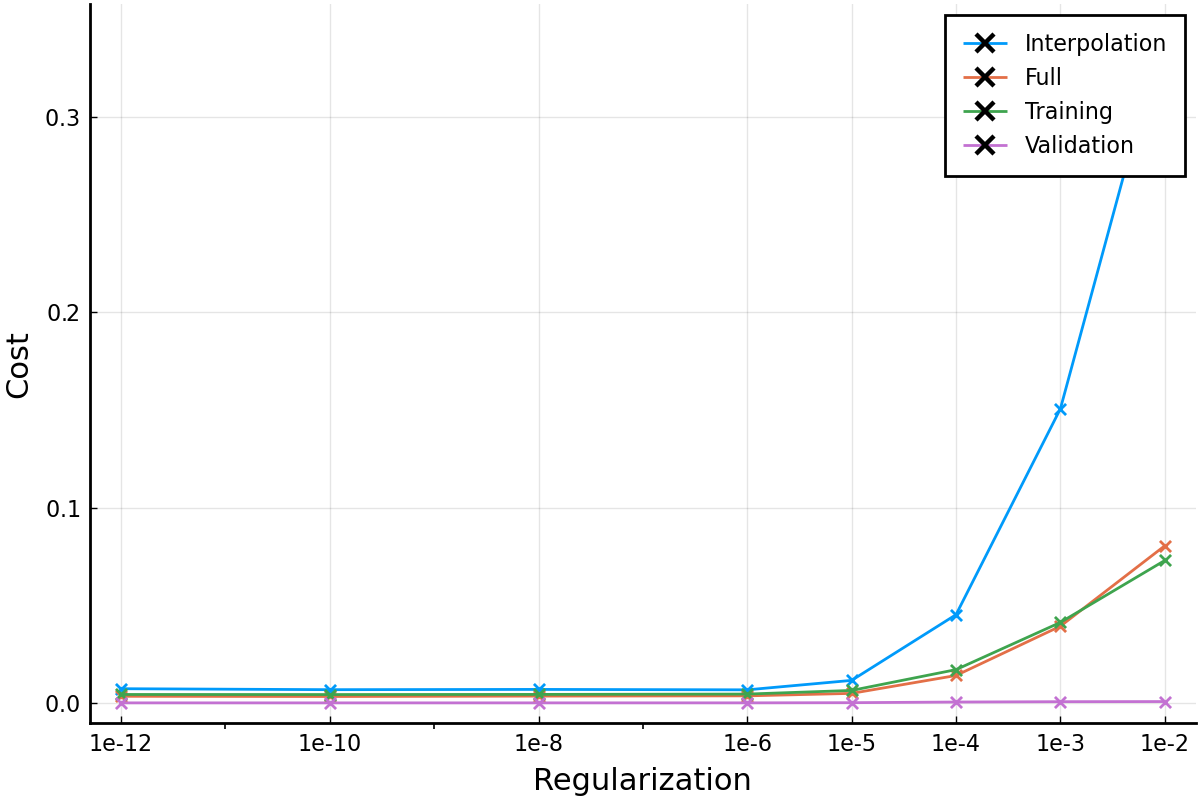

In [129]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_1em1.bson" a b c d
plot_regularization([1e-1], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], a, b, c, d)

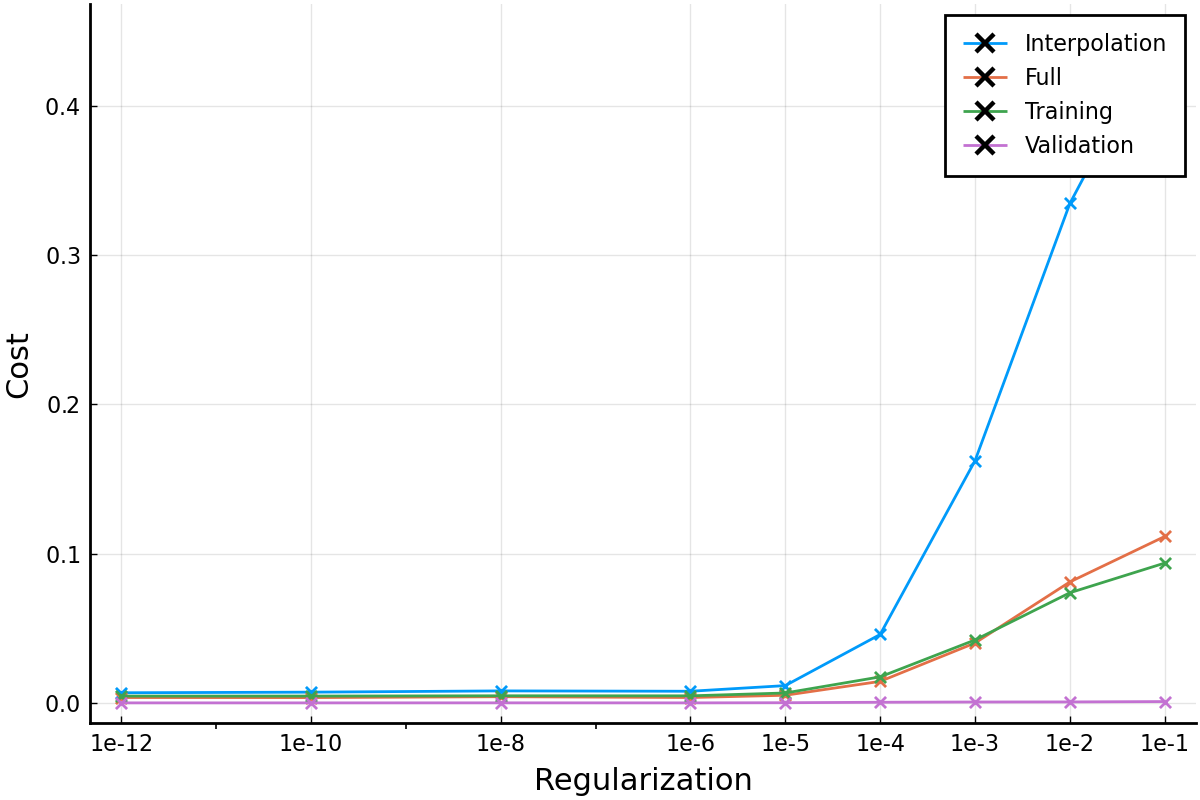

In [24]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_gauss_10p.bson" a b c d
plot_regularization([1e-1], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], a, b, c, d)

--- 
### Check L2 regularized model

In [44]:
@load "./src/examples/heat/reg/HeatLinearModelExperiment_noise_gauss_10p_2.bson" K p

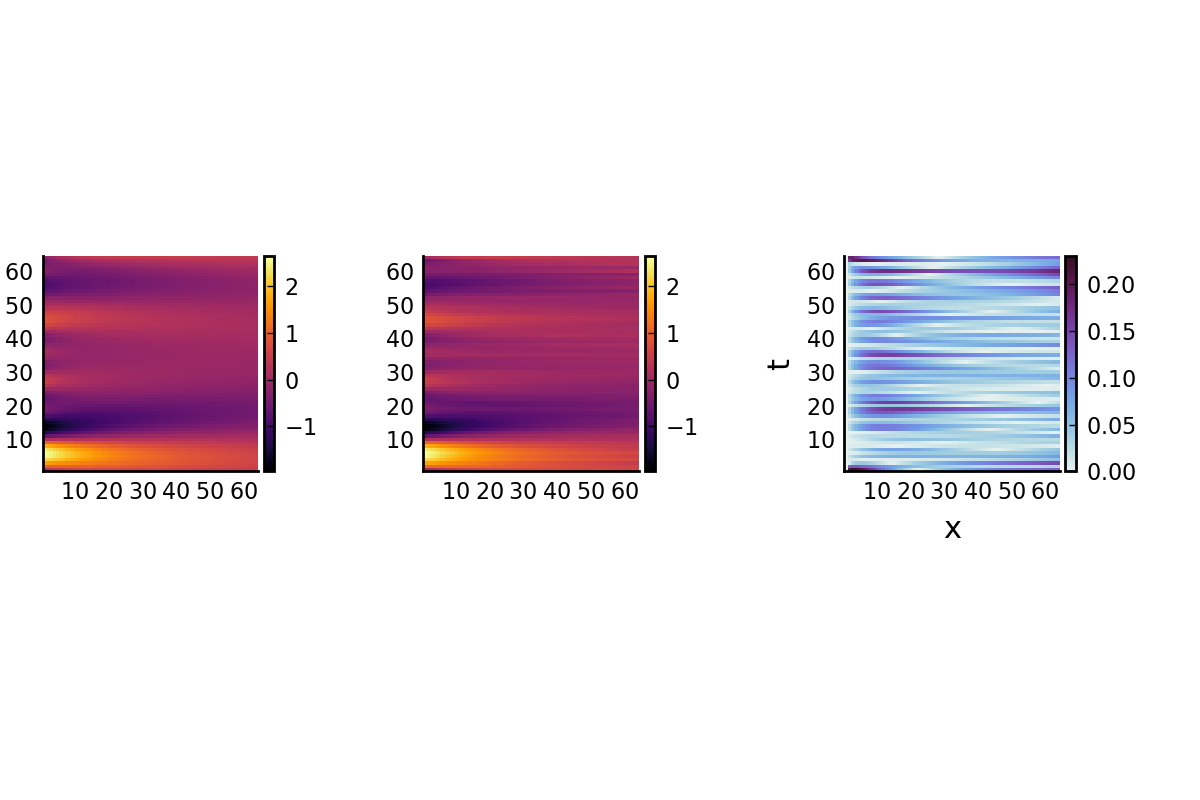

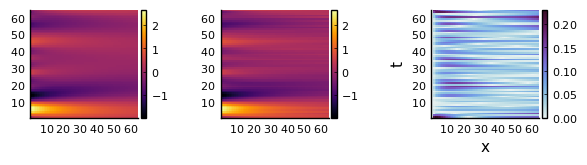

In [45]:
check_result(K, p, 2)

## Training with NeuralODE object

In [ ]:
callback(theta, loss, u) = (IJulia.clear_output(true); display(loss); false)

In [ ]:
function heat_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-8 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset);
net = Models.HeatModel(x_n);
result = heat_training(net, 2, init_set, true_set, t);

### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
dLdK = first(Zygote.gradient(loss, K))
GraphicTools.show_state(reverse(dLdK; dims=1), "dLdK")

In [ ]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 2, kappa, k);
u_pred = Array(S(K, u0, t));

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

---

## Training with solver

In [ ]:
function f(u, K, t)
  return K * u
end

In [ ]:
function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
callback(A, loss) = (println(loss); flush(stdout); false)

In [ ]:
function heat_training_solver(A, epochs, u0, u_true, tsnap)
    
  function loss(A)
    u_pred = Array(S(A, u0, tsnap))
    l = Objectives.mseloss(u_pred, u_true)
    return l
  end

  result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = epochs);
  return result
end

In [ ]:
net = zeros(x_n, x_n);

### Train with different data sets

Hand (data obtained from analytical solution), analytical (analytical solution at t=0 + ode solver), high dimension data set (from burgers to generate shock).

In [ ]:
t4, u04, u_true4 = ProcessingTools.process_dataset(hand_dataset);
result_5 = heat_training_solver(copy(net), 100, u04, u_true4, t4);


In [ ]:
t, u0, u_true = ProcessingTools.process_dataset(analytic_dataset);
result_2 = heat_training_solver(copy(net), 100, u0, u_true, t);


In [ ]:
t2, init, train = syver_dataset;
result_3 = heat_training_solver(copy(net), 1000, init, train, t2);


In [ ]:
t3, u03, u_true3 = ProcessingTools.process_dataset(high_dataset);
result_4 = heat_training_solver(copy(net), 100, u03, u_true3, t3);


In [ ]:
K2 = result_2.u
K3 = result_3.u;
K4 = result_4.u;
K5 = result_5.u;

display(
    plot(
        GraphicTools.show_state(reverse(K2; dims = 1), ""),
        GraphicTools.show_state(reverse(K3; dims = 1), ""),
        GraphicTools.show_state(reverse(K4; dims = 1), ""),
        GraphicTools.show_state(reverse(K5; dims = 1), "");
        layout = (2, 2),
    ),
);  

In [ ]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 4, kappa, k);
u_pred_2 = Array(S(K2, u0, t));
u_pred_3 = Array(S(K3, u0, t));
u_pred_4 = Array(S(K4, u0, t));

display(
    plot(
        GraphicTools.show_state(u, "data"),
        GraphicTools.show_state(u_pred_2, "prediction 2"),
        GraphicTools.show_state(u_pred_3, "prediction 3"),
        GraphicTools.show_state(u_pred_4, "prediction 4");
        layout = (2, 2),
        reuse = false
    ),
);

In [ ]:
function test_simulation(net, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, typ, kappa, k);
        u_pred = Array(S(net, u0, t));
        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

In [ ]:
println(test_simulation(K2, 100, 1))
println(test_simulation(K2, 100, 2))
println(test_simulation(K2, 100, 3))
println(test_simulation(K2, 100, 4))

In [ ]:
println(test_simulation(K3, 100, 1))
println(test_simulation(K3, 100, 2))
println(test_simulation(K3, 100, 3))
println(test_simulation(K3, 100, 4))

In [ ]:
println(test_simulation(K4, 100, 1))
println(test_simulation(K4, 100, 2))
println(test_simulation(K4, 100, 3))
println(test_simulation(K4, 100, 4))